### Data Filling

This notebook is going to be used to fill out those rows that have 0 values for all count of orcas, Adults, Juveniles and those of uncertain age.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('../data/clean_data.csv')
df.head()

,date,Latitude,Longitude,Followed_GTOA_Protocol,Interaction_time,Boat_Type,Boat_Length,Towing_Inflatable,Trailing_Fishing_Lure,Physical_Contact_With_Boat,Number_of_Adult_Orcas,Number_of_Juvenile_Orcas,Number_of_Uncertain_Age_Orcas,Rudder,Motoring_or_Sailing,Speed_Knots,Sea_State,Wind_Speed_Beaufort,Daylight_or_Darkness,Cloud_Cover,Distance_Off_Land_NM,Depth_Meters,Depth_Gauge,Autopilot,Hull_Topsides_Color,Antifoul_Color,Boat_Damaged,Tow_Required,Crew_Response,Orcas_Behaviour
0,2023-11-01 22:15:00,32.791633,-9.906633,No,0-10,Sail,10-12.5,No,No,No,1,0,0,Spade,Sailing,5 - 7,Moderate,5 - 6 (17 - 27 knots),Night,0 - 25%,Over 10,200m+,On,On,White/light,Blue,No,No,"Orca interaction at 10:15pm on 01/11, 40 miles...",I would describe the behaviour of the Orca dur...
1,2023-10-31 07:50:00,39.433333,-9.383333,Yes,0-10,Sail,12.5-15,No,No,Yes,2,5,0,Twin rudder,Motoring,5 - 7,Rough,3 - 4 (7 - 16 knots),Day,50 - 75%,2 - 5,40 - 200m,On,On,White/light,Black,"Yes, moderate - immediate repairs required",No,We had sandbags on our sugar scoops and metal ...,Juveniles hitting the rudders adults close by
2,2023-09-19 11:00:00,37.666667,-8.900000,No,0-10,Sail,12.5-15,No,No,Yes,1,0,0,Spade,Motoring,5 - 7,Calm,3 - 4 (7 - 16 knots),Day,0 - 25%,2 - 5,40 - 200m,On,On,White/light,Other,"Yes, moderate - immediate repairs required",No,We saw the orca approach from 10 o’clock posit...,There was an initial approach 45 minutes earli...
3,2023-09-01 13:15:00,45.600000,-3.750000,Yes,10-30,Sail,15+,No,Yes,Yes,1,2,0,Spade,Sailing,3 - 4,Calm,3 - 4 (7 - 16 knots),Day,25 - 50%,Over 10,200m+,Off,Off,White/light,Black,"Yes, moderate - immediate repairs required",No,Les trois orques passent constamment de bâbord...,Pas de comportement visblement agressif./// No...
4,2023-09-02 03:45:00,42.750000,-9.233333,Yes,0-10,Sail,12.5-15,No,No,Yes,1,2,0,Spade,Motorsailing,5 - 7,Calm,0 - 2 (0 - 6 knots),Night,0 - 25%,5 - 10,40 - 200m,On,On,White/light,Black,"Yes, moderate - immediate repairs required",Yes,Arrêt du pilote automatique a la 2 eme interac...,Approche furtive à la première interaction dir...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           153 non-null    object 
 1   Latitude                       153 non-null    float64
 2   Longitude                      153 non-null    float64
 3   Followed_GTOA_Protocol         153 non-null    object 
 4   Interaction_time               153 non-null    object 
 5   Boat_Type                      153 non-null    object 
 6   Boat_Length                    153 non-null    object 
 7   Towing_Inflatable              153 non-null    object 
 8   Trailing_Fishing_Lure          153 non-null    object 
 9   Physical_Contact_With_Boat     153 non-null    object 
 10  Number_of_Adult_Orcas          153 non-null    int64  
 11  Number_of_Juvenile_Orcas       153 non-null    int64  
 12  Number_of_Uncertain_Age_Orcas  153 non-null    int

In [4]:
# Desconozco por qué me ha cambiado el tipo de dato de la columan date a tipo objeto pero voy a devolverla a datetime y prosigo con la tarea
# principal de este notebook.

df.date = df.date.astype('datetime64[ms]')
print(df.date.dtype)

datetime64[ms]


Vamos a filtrar aquellas filas que tengan un 0 en las tres columnas, y de ahí sirviéndonos de las información contenida en las columnas Crew_Response y Orcas_Behaviourse van a tomar las siguientes métricas para ser coherentes en el estudio:
* Solamente en caso de no decir el patron nada al respecto de cuantas orcas había, se rellenará el valor de 'Uncertain' con un valor de 1 por haberse dado una interacción. 
* En caso de mencionar el patrón un número pero no la edad o el tamaño, se meterán en la columna de 'Uncertain'
* En caso de decir el patrón que las orcas eran de tamaño considerable/grande, se considerarán estas orcas adultas.
* En caso de decir el patrón que las orcas eran pequeñas o crías, se considerán estas orcas como juveniles.
* Cuando se de un ranog, siempre se toma el rango inferior.

In [11]:
# Creamos un dataframe separado únicamente para mostrar aquellas filas que tengan un 0 en las tres columnas de recuento de orcas

# Luego iremos rellenando sobre el dataframe original df.

# Filas filtradas donde todos los recuentos sean 0
filtered_rows = df[(df['Number_of_Adult_Orcas'] == 0) & 
                   (df['Number_of_Juvenile_Orcas'] == 0) & 
                   (df['Number_of_Uncertain_Age_Orcas'] == 0)]

# Hago print de todas las filas que cumplan la condición, con estas 3 columnas me vale para poder ubicar los comentarios de la tripulación acerca de la interacción.
print(filtered_rows[['date', 'Latitude', 'Longitude']])


                   date   Latitude  Longitude
23  2023-05-25 14:00:00  36.016667  -5.933333
25  2023-05-14 20:30:00  36.068250  -6.863317
26  2023-04-29 08:00:00  36.100000  -5.900000
27  2023-05-12 15:00:00  36.116667  -5.967500
28  2023-05-07 06:30:00  35.991567  -5.990517
29  2023-05-11 16:35:00  36.126667  -5.965000
30  2023-05-08 22:30:00  35.890000  -5.805000
31  2022-08-06 07:05:00  47.460000  -5.057667
32  2023-05-06 18:50:00  36.083333  -5.966667
33  2023-05-06 12:53:00  36.148283  -6.036417
34  2023-04-11 11:10:00  36.055833  -6.188333
35  2023-05-01 13:20:00  36.125000  -5.888333
36  2023-05-05 00:12:00  35.993750  -5.976333
37  2023-03-31 22:30:00  36.376667  -7.688333
38  2023-04-28 18:08:00  36.166667  -7.066667
39  2023-04-25 19:00:00  35.916667  -5.733333
40  2023-04-20 10:45:00  35.884167  -5.839833
41  2023-03-27 11:15:00  35.883333  -5.833333
42  2023-03-25 13:45:00  39.510333  -9.408667
43  2023-03-23 22:30:00  38.104333  -9.179000
44  2023-03-10 07:15:00  35.822600

Procedemos a hacer la asignación de valores siguiendo las métricas previamente comentadas. Se hará en grupos de 10 filas.

In [12]:
df.Number_of_Adult_Orcas.value_counts()

Number_of_Adult_Orcas
0    134
1     12
2      3
5      1
6      1
4      1
3      1
Name: count, dtype: int64

In [13]:
df.Number_of_Juvenile_Orcas.value_counts()

Number_of_Juvenile_Orcas
0    144
2      6
5      2
1      1
Name: count, dtype: int64

In [14]:
df.Number_of_Uncertain_Age_Orcas.value_counts()

Number_of_Uncertain_Age_Orcas
0    141
4      4
2      2
3      2
5      2
6      1
7      1
Name: count, dtype: int64

In [15]:
# Rows 23 to 33
df.loc[23, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[25, 'Number_of_Uncertain_Age_Orcas'] = 5
df.loc[26, 'Number_of_Juvenile_Orcas'] = 2
df.loc[27, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[28, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[29, 'Number_of_Uncertain_Age_Orcas'] = 3
df.loc[30, 'Number_of_Adult_Orcas'] = 1
df.loc[30, 'Number_of_Juvenile_Orcas'] = 1
df.loc[30, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[31, 'Number_of_Juvenile_Orcas'] = 3
df.loc[32, 'Number_of_Juvenile_Orcas'] = 1
df.loc[32, 'Number_of_Adult_Orcas'] = 2
df.loc[33, 'Number_of_Uncertain_Age_Orcas'] = 1

In [23]:
# Rows 34 to 43
df.loc[34, 'Number_of_Adult_Orcas'] = 3
df.loc[34, 'Number_of_Juvenile_Orcas'] = 1
df.loc[35, 'Number_of_Adult_Orcas'] = 3
df.loc[36, 'Number_of_Adult_Orcas'] = 1
df.loc[36, 'Number_of_Juvenile_Orcas'] = 2
df.loc[37, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[38, 'Number_of_Uncertain_Age_Orcas'] = 6
df.loc[39, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[40, 'Number_of_Uncertain_Age_Orcas'] = 5
df.loc[41, 'Number_of_Adult_Orcas'] = 1
df.loc[41, 'Number_of_Juvenile_Orcas'] = 2
df.loc[42, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[43, 'Number_of_Uncertain_Age_Orcas'] = 2


In [26]:
# Rows 44 to 53
df.loc[44, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[45, 'Number_of_Uncertain_Age_Orcas'] = 3
df.loc[46, 'Number_of_Uncertain_Age_Orcas'] = 4
df.loc[47, 'Number_of_Adult_Orcas'] = 2
df.loc[47, 'Number_of_Juvenile_Orcas'] = 3
df.loc[48, 'Number_of_Uncertain_Age_Orcas'] = 6
df.loc[49, 'Number_of_Adult_Orcas'] = 1
df.loc[49, 'Number_of_Juvenile_Orcas'] = 2
df.loc[50, 'Number_of_Adult_Orcas'] = 2
df.loc[50, 'Number_of_Uncertain_Age_Orcas'] = 6
df.loc[51, 'Number_of_Adult_Orcas'] = 4
df.loc[51, 'Number_of_Juvenile_Orcas'] = 1
df.loc[52, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[53, 'Number_of_Uncertain_Age_Orcas'] = 1

In [27]:
# Rows 54 to 63
df.loc[54, 'Number_of_Uncertain_Age_Orcas'] = 6
df.loc[55, 'Number_of_Uncertain_Age_Orcas'] = 4
df.loc[56, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[57, 'Number_of_Uncertain_Age_Orcas'] = 4
df.loc[58, 'Number_of_Adult_Orcas'] = 1
df.loc[58, 'Number_of_Juvenile_Orcas'] = 2
df.loc[58, 'Number_of_Uncertain_Age_Orcas'] = 6
df.loc[59, 'Number_of_Adult_Orcas'] = 4
df.loc[59, 'Number_of_Juvenile_Orcas'] = 2
df.loc[60, 'Number_of_Uncertain_Age_Orcas'] = 5
df.loc[61, 'Number_of_Adult_Orcas'] = 3
df.loc[61, 'Number_of_Juvenile_Orcas'] = 3
df.loc[62, 'Number_of_Uncertain_Age_Orcas'] = 5
df.loc[63, 'Number_of_Uncertain_Age_Orcas'] = 6

In [29]:
# Rows 64 to 73
df.loc[64, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[65, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[66, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[67, 'Number_of_Adult_Orcas'] = 1
df.loc[67, 'Number_of_Juvenile_Orcas'] = 1
df.loc[67, 'Number_of_Uncertain_Age_Orcas'] = 6
df.loc[68, 'Number_of_Uncertain_Age_Orcas'] = 4
df.loc[69, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[70, 'Number_of_Uncertain_Age_Orcas'] = 8
df.loc[71, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[72, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[73, 'Number_of_Uncertain_Age_Orcas'] = 4

In [31]:
# Rows 74 to 83
df.loc[74, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[75, 'Number_of_Adult_Orcas'] = 1
df.loc[76, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[77, 'Number_of_Adult_Orcas'] = 4
df.loc[77, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[78, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[79, 'Number_of_Adult_Orcas'] = 3
df.loc[79, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[80, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[81, 'Number_of_Adult_Orcas'] = 1
df.loc[81, 'Number_of_Uncertain_Age_Orcas'] = 3
df.loc[82, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[83, 'Number_of_Adult_Orcas'] = 3

In [32]:
# Rows 84 to 93
df.loc[84, 'Number_of_Adult_Orcas'] = 3
df.loc[85, 'Number_of_Juvenile_Orcas'] = 1
df.loc[85, 'Number_of_Adult_Orcas'] = 5
df.loc[86, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[87, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[88, 'Number_of_Juvenile_Orcas'] = 2
df.loc[89, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[90, 'Number_of_Adult_Orcas'] = 4
df.loc[90, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[91, 'Number_of_Adult_Orcas'] = 1
df.loc[91, 'Number_of_Juvenile_Orcas'] = 2
df.loc[91, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[92, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[93, 'Number_of_Adult_Orcas'] = 3
df.loc[93, 'Number_of_Juvenile_Orcas'] = 3
df.loc[93, 'Number_of_Uncertain_Age_Orcas'] = 3

In [33]:
# Rows 94 to 103
df.loc[94, 'Number_of_Uncertain_Age_Orcas'] = 6
df.loc[95, 'Number_of_Adult_Orcas'] = 2
df.loc[96, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[97, 'Number_of_Adult_Orcas'] = 1
df.loc[97, 'Number_of_Juvenile_Orcas'] = 1
df.loc[98, 'Number_of_Uncertain_Age_Orcas'] = 6
df.loc[99, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[100, 'Number_of_Uncertain_Age_Orcas'] = 5
df.loc[101, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[102, 'Number_of_Adult_Orcas'] = 4
df.loc[102, 'Number_of_Juvenile_Orcas'] = 4
df.loc[103, 'Number_of_Uncertain_Age_Orcas'] = 6

In [34]:
# Rows 104 to 113
df.loc[104, 'Number_of_Adult_Orcas'] = 2
df.loc[104, 'Number_of_Juvenile_Orcas'] = 1
df.loc[105, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[106, 'Number_of_Adult_Orcas'] = 1
df.loc[106, 'Number_of_Juvenile_Orcas'] = 1
df.loc[107, 'Number_of_Adult_Orcas'] = 2
df.loc[107, 'Number_of_Juvenile_Orcas'] = 2
df.loc[108, 'Number_of_Uncertain_Age_Orcas'] = 12
df.loc[109, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[110, 'Number_of_Uncertain_Age_Orcas'] = 6
df.loc[111, 'Number_of_Adult_Orcas'] = 1
df.loc[111, 'Number_of_Juvenile_Orcas'] = 1
df.loc[112, 'Number_of_Adult_Orcas'] = 3
df.loc[112, 'Number_of_Juvenile_Orcas'] = 3 
df.loc[113, 'Number_of_Juvenile_Orcas'] = 2

In [35]:
# Rows 114 to 123
df.loc[114, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[115, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[116, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[117, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[118, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[119, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[120, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[121, 'Number_of_Adult_Orcas'] = 1
df.loc[121, 'Number_of_Juvenile_Orcas'] = 2
df.loc[122, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[123, 'Number_of_Uncertain_Age_Orcas'] = 1

In [36]:
# Rows 124 to 133
df.loc[124, 'Number_of_Juvenile_Orcas'] = 1
df.loc[125, 'Number_of_Uncertain_Age_Orcas'] = 3
df.loc[126, 'Number_of_Juvenile_Orcas'] = 2
df.loc[127, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[128, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[129, 'Number_of_Adult_Orcas'] = 4
df.loc[129, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[130, 'Number_of_Adult_Orcas'] = 2
df.loc[131, 'Number_of_Juvenile_Orcas'] = 1
df.loc[131, 'Number_of_Uncertain_Age_Orcas'] = 5
df.loc[132, 'Number_of_Uncertain_Age_Orcas'] = 3
df.loc[133, 'Number_of_Adult_Orcas'] = 2
df.loc[133, 'Number_of_Juvenile_Orcas'] = 1

In [37]:
# Rows 134 to 146
df.loc[134, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[135, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[136, 'Number_of_Uncertain_Age_Orcas'] = 3
df.loc[137, 'Number_of_Uncertain_Age_Orcas'] = 4
df.loc[138, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[139, 'Number_of_Uncertain_Age_Orcas'] = 4
df.loc[140, 'Number_of_Uncertain_Age_Orcas'] = 6
df.loc[142, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[144, 'Number_of_Uncertain_Age_Orcas'] = 1
df.loc[146, 'Number_of_Uncertain_Age_Orcas'] = 2

In [38]:
# Rows 147 to 152
df.loc[147, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[148, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[149, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[150, 'Number_of_Adult_Orcas'] = 2
df.loc[150, 'Number_of_Juvenile_Orcas'] = 2
df.loc[150, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[151, 'Number_of_Uncertain_Age_Orcas'] = 3
df.loc[151, 'Number_of_Uncertain_Age_Orcas'] = 2
df.loc[152, 'Number_of_Adult_Orcas'] = 1
df.loc[152, 'Number_of_Juvenile_Orcas'] = 1

In [43]:
# Vamos a hacer un recuento de valores para cada una de las 3 columnas para ver como se distribuyen los resultados:
df.Number_of_Adult_Orcas.value_counts()

Number_of_Adult_Orcas
0    96
1    26
2    12
3     9
4     7
5     2
6     1
Name: count, dtype: int64

In [44]:
df.Number_of_Juvenile_Orcas.value_counts()

Number_of_Juvenile_Orcas
0    111
2     19
1     15
3      5
5      2
4      1
Name: count, dtype: int64

In [45]:
df.Number_of_Uncertain_Age_Orcas.value_counts()

Number_of_Uncertain_Age_Orcas
0     47
2     37
1     25
6     13
4     11
3      9
5      8
7      1
8      1
12     1
Name: count, dtype: int64

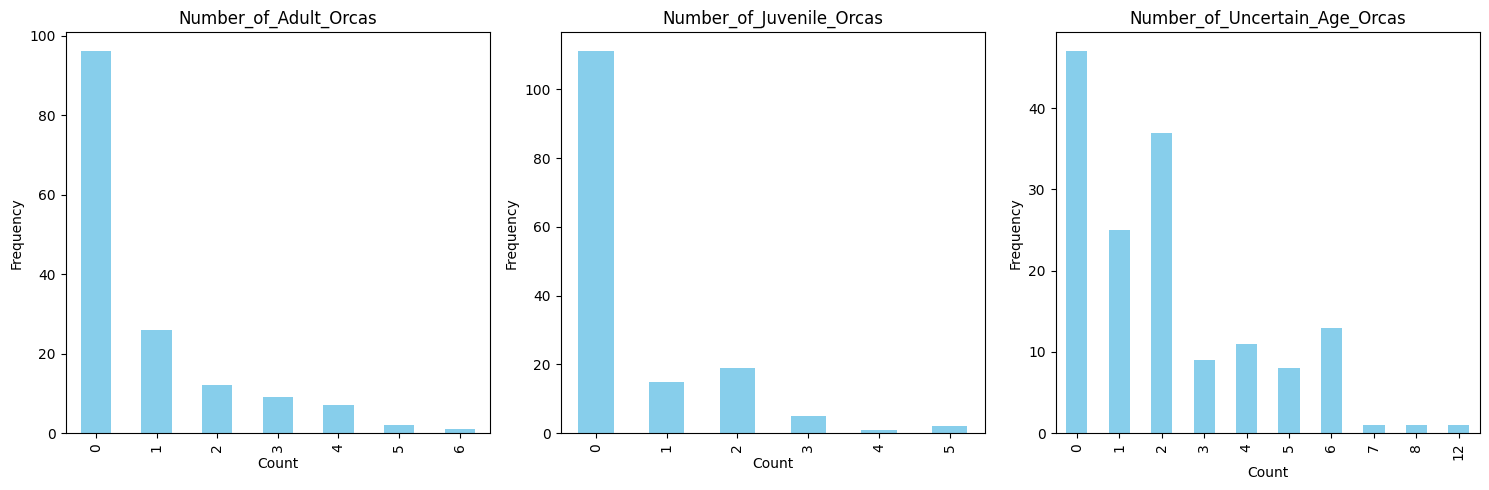

In [50]:
# Vamos a hacer un plot rápidamente de la distribución de los valores para cada una de las columnas:
# Columnas a mostrar:
columns_to_plot = ['Number_of_Adult_Orcas', 'Number_of_Juvenile_Orcas', 'Number_of_Uncertain_Age_Orcas']

# Creamos subplots
fig, axes = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(15, 5))

# Plot histograms for each column
for i, column in enumerate(columns_to_plot):
    df[column].value_counts().sort_index().plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(column)
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [48]:
# Guardamos el df completo en formato csv en nuestra carpeta de data
df.to_csv('../data/full_data.csv', index=True)